## 2-way ANOVA

https://raphaelvallat.com/pingouin.html#:~:text=import%20pingouin%20as%20pg%20%23%20Compute%20the%20two-way,indeed%20a%20significant%20interaction%2C%20F%20%282%2C%20116%29%3D3.45%2C%20p%3D.035.

## Tutorial Example

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import pingouin as pg
import seaborn as sns

In [2]:
# Let's assume that we have a balanced design with 30 students in each group
n = 30
months = ['August', 'January', 'June']

# Generate random data
np.random.seed(1234)
control = np.random.normal(5.5, size=len(months) * n)
meditation = np.r_[ np.random.normal(5.4, size=n),
                    np.random.normal(5.8, size=n),
                    np.random.normal(6.4, size=n) ]

# Create a dataframe
df = pd.DataFrame({'Scores': np.r_[control, meditation],
                   'Time': np.r_[np.repeat(months, n), np.repeat(months, n)],
                   'Group': np.repeat(['Control', 'Meditation'], len(months) * n),
                   'Subject': np.r_[np.tile(np.arange(n), 3),
                                    np.tile(np.arange(n, n + n), 3)]})

<AxesSubplot:xlabel='Time', ylabel='Scores'>

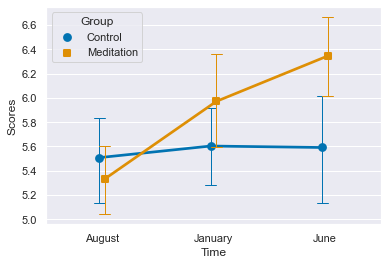

In [3]:
sns.set()
sns.pointplot(data=df, x='Time', y='Scores', hue='Group', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')

In [4]:
df.groupby(['Time', 'Group'])['Scores'].agg(['mean', 'std']).round(2)

mean   std
Time    Group                 
August  Control     5.51  1.03
        Meditation  5.33  0.81
January Control     5.60  0.90
        Meditation  5.97  1.07
June    Control     5.59  1.18
        Meditation  6.35  0.93

In [5]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='Scores', within='Time', between='Group', subject='Subject', data=df)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
Group        4.465      1     58  4.465  4.131    0.047  0.066  nan
Time         9.359      2    116  4.679  4.941    0.009  0.078    0.998
Interaction  6.539      2    116  3.270  3.452    0.035  0.056  nan



In [6]:
posthocs = pg.pairwise_ttests(dv='Scores', within='Time', between='Group',
                              subject='Subject', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast      Time     A        B           Paired    Parametric         T     dof  alternative      p-unc    BF10    hedges
------------  -------  -------  ----------  --------  ------------  ------  ------  -------------  -------  ------  --------
Time          -        August   January     True      True          -2.002  59.000  two-sided        0.050   0.908    -0.379
Time          -        August   June        True      True          -2.985  59.000  two-sided        0.004   7.594    -0.530
Time          -        January  June        True      True          -1.024  59.000  two-sided        0.310   0.232    -0.170
Group         -        Control  Meditation  False     True          -2.033  58.000  two-sided        0.047   1.447    -0.518
Time * Group  August   Control  Meditation  False     True           0.733  58.000  two-sided        0.466   0.329     0.187
Time * Group  January  Control  Meditation  False     True          -1.434  58.000  two-sided        0.157  

/Users/dankoban/opt/anaconda3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


## VCF Study Analysis

### Categorical Risk

In [7]:
result = pyreadr.read_r("/Users/dankoban/Documents/holding_gwu_dissertation/data/vcf_data_for_python.RData")
vcf_data = result["vcf_data"]

/Users/dankoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:528: RuntimeWarning: invalid value encountered in multiply
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [8]:
pre = vcf_data[['participant_id', 'group', 'base_gist_cat']].rename(columns={'base_gist_cat': 'score'})
pre = pre.assign(time = "pretest")
post = vcf_data[['participant_id', 'group', 'gist_cat_6']].rename(columns={'gist_cat_6': 'score'})
post = post.assign(time = "posttest")
df = pre.append(post, ignore_index=True)
df.groupby(['time', 'group'])['score'].agg(['mean', 'std']).round(2)

mean    std
time     group                  
posttest Control    36.52   9.19
         Treatment  35.50  10.42
pretest  Control    34.22   7.70
         Treatment  33.46   8.16

<AxesSubplot:xlabel='time', ylabel='score'>

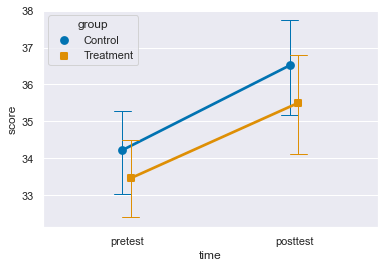

In [9]:
sns.set()
sns.pointplot(data=df, x='time', y='score', hue='group', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')

In [10]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='score', within='time', between='group', subject='participant_id', data=df)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  -------  -----  -----  -------  ------  -------  -----  -------
group        155.566      1    395  155.566   1.193    0.275  0.003  nan
time         922.841      1    395  922.841  29.926    0.000  0.070    1.000
Interaction    3.278      1    395    3.278   0.106    0.745  0.000  nan



In [11]:
pg.normality(df, dv='score', group='group')

,W,pval,normal
group,,,
Control,0.986984,0.002878,False
Treatment,0.981767,0.000025,False


### Ordinal Risk

In [12]:
pre = vcf_data[['participant_id', 'group', 'base_global']].rename(columns={'base_global': 'score'})
pre = pre.assign(time = "pretest")
post = vcf_data[['participant_id', 'group', 'global_6']].rename(columns={'global_6': 'score'})
post = post.assign(time = "posttest")
df = pre.append(post, ignore_index=True)
df.groupby(['time', 'group'])['score'].agg(['mean', 'std']).round(2)

mean   std
time     group                
posttest Control    4.47  1.25
         Treatment  4.57  1.39
pretest  Control    4.65  1.32
         Treatment  4.58  1.31

<AxesSubplot:xlabel='time', ylabel='score'>

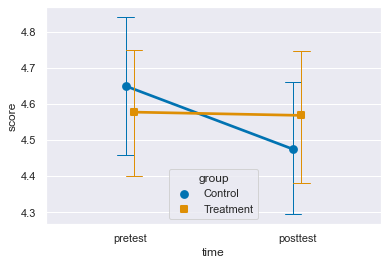

In [13]:
sns.set()
sns.pointplot(data=df, x='time', y='score', hue='group', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')

In [14]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='score', within='time', between='group', subject='participant_id', data=df)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
group        0.022      1    395  0.022  0.008    0.929  0.000  nan
time         1.372      1    395  1.372  1.979    0.160  0.005    1.000
Interaction  1.352      1    395  1.352  1.951    0.163  0.005  nan

